# Tree-Based Methods

У цьому уроці ми дізнаємося, як реалізовувати та налаштовувати `tree-based` моделі, включаючи Random Forest, XGBoost та LightGBM. Ми також вивчимо криву AUC - ROC, яка показує наскільки модель здатна розрізняти класи.

Ми використаємо [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic). Нагадаємо опис полів  ([see in detail](https://www.kaggle.com/c/titanic/data)):

+ **survival** -- Survival: 0 = No, 1 = Yes
+ **pclass** -- Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
+ **sex** -- Sex
+ **Age** -- Age in years
+ **sibsp** -- # of siblings / spouses aboard the Titanic
+ **parch** -- # of parents / children aboard the Titanic
+ **ticket** -- Ticket number
+ **fare** -- Passenger fare
+ **cabin** -- Cabin number
+ **embarked** -- Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton
  

## Rreferences
- [Titanic: Machine Learning from Disaster (Kaggle Challenge)](https://www.kaggle.com/c/titanic)
- [Titanic: Machine Learning from Disaster – Kaggle Competition Solution using Python](http://blog.chapagain.com.np/titanic-machine-learning-from-disaster-kaggle-competition-solution-python/)
- [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Titanic Random Forest](https://www.kaggle.com/viczyf/titanic-random-forest-82-78)
- [How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c)
- [Titanic survival prediction in Python with XGBoost](https://www.kaggle.com/ihopethiswillfi/titanic-survival-prediction-in-python-with-xgboost)
- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [XGBoost Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
- [GitHub - dmlc/xgboost](https://github.com/dmlc/xgboost)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
- [GitHub - microsoft/LightGBM](https://github.com/microsoft/LightGBM)
- [GitHub - microsoft/LightGBM/Features](https://github.com/microsoft/LightGBM/blob/master/docs/Features.rst)
- [Gradient Boosting, Decision Trees and XGBoost with CUDA](https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/)
- [Graphviz - Graph Visualization Software](https://graphviz.gitlab.io/)
- [How to Visualize Gradient Boosting Decision Trees With XGBoost in Python](https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/)
- [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
- [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

<a name="1"></a>
## 1. Preprocessing

<a name="1-1"></a>
### 1.1. Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load useful libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn.metrics import roc_curve, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

In [ ]:
TRAIN_DATA_PATH = "/content/drive/MyDrive/HillelIT/data/titanic_train_data.csv"
TEST_DATA_PATH = "/content/drive/MyDrive/HillelIT/data/titanic_test_data.csv"

In [ ]:
# Load data
train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

In [ ]:
train

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [ ]:
dataset = [train, test]

print("Shape of the train dataframe =", train.shape)
print("Shape of the test dataframe =", test.shape)

train.head()

Shape of the train dataframe = (891, 12)
Shape of the test dataframe = (418, 11)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [ ]:
test.head()

<a name="1-2"></a>
### 1.2. Check the data

In [ ]:
# Check missing values in train data
print(f"Missing values in the training set:\n{train.isnull().sum()}\n")
print(f"Missing values in the test set:\n{test.isnull().sum()}")

Missing values in the training set:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in the test set:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


<a name="1-3"></a>
### 1.3. Transform the data

Зверніть увагу на нову функцію `Title`.

Meanings:

    Mr - any man
    Mrs - married woman who uses her husband's last name
    Miss -  unmarried woman
    Ms - married or unmarried woman (common in business)
    Master - minor male
    Don - male that around 40s
    Dona - female that around 40s
    Sir - adult male of any age
    Lady - adult female of any age
    Dr - Doctor
    Rev - Reverend
    Mme - Madame
    Mlle - Mademoiselle
    Major - Rank in the Military
    Col - Colonel
    Capt - Captain
    Countess - Wife of a Count
    Jonkheer - a rank for nobility

In [ ]:
for data in dataset:
    # Fill missing values of Age and Fare with median values
    data['Age'] = data['Age'].fillna(value=data['Age'].median())
    data['Fare'] = data['Fare'].fillna(value=data['Fare'].median())
    data["Embarked"] = data["Embarked"].fillna(value="S")   # because "S" is the most common port of embarkation

    # Create a new feature
    data["FamilySize"] = 1 + data["Parch"] + data["SibSp"]

    # Create a `Title` feature
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.')
    data['Title'] = data['Title'].replace(['Ms', 'Mlle'], 'Miss')
    data['Title'] = data['Title'].replace(['Mme', 'Countess', 'Lady', 'Dona'], 'Mrs')
    data['Title'] = data['Title'].replace(['Dr', 'Major', 'Col', 'Sir'], 'Mr')
    data['Title'] = data['Title'].replace(['Rev', 'Jonkheer', 'Capt', 'Don'], 'Mr')

    # Replace string values with numbers
    data["Sex"] = data["Sex"].map({"male": 1, "female": 0}).astype(int)
    data["Embarked"] = data["Embarked"].map({"S": 1, "C": 2, "Q": 3}).astype(int)
    data['Title'] = data['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3}).astype(int)


# Check missing Age and Fare values
print("Check missing values:")
print("  Train: Age - {}, Fare - {}".format(train.Age.isnull().sum(), train.Fare.isnull().sum()))
print("  Test : Age - {}, Fare - {}".format(test.Age.isnull().sum(), test.Fare.isnull().sum()))

train.head()

Check missing values:
  Train: Age - 0, Fare - 0
  Test : Age - 0, Fare - 0


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare Cabin  Embarked  FamilySize  Title  
0         A/5 21171   7.2500   NaN         1           2      0  
1          PC 17599  71.2833   C85         2           2      2  
2  STON/O2. 3101282   7.9250   NaN         1           1      1  
3            113803  53.1000  C123         1           2      2  
4            373450   8.0500   NaN         1           1      0

<a name="1-4"></a>
### 1.4. Define tree training function

Зверніть увагу, що `model.feature_importances_` повертає важливість функцій `model` (чим вище, тим важливіша функція).

In [ ]:
def train_tree_model(X, y, model, params):
    """
    Train a tree-based model.

    Args:
        X (pd.DataFrame): input feature examples, size (n_examples, n_features)
        y (pd.Series): labels, size (n_examples,)
        model (sklearn, xgboost or lightgbm): a tree-based model
        params (dict): GridSearchCV's parameters
    Returns:
        model (sklearn, xgboost or lightgbm): a trained tree-based model
    """

    # Split the data
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

    # Display the current grid of parameters
    print("PARAMETER GRID:")
    print(f"(number of grid elements: {len(ParameterGrid(params))})")
    print(*list(ParameterGrid(params))[:10], sep="\n")
    print("...........................................\n")

    # Set a GridSearch model
    grid_model = GridSearchCV(model, params, cv=5)

    # Train the GridSearch model
    grid_model.fit(X_train, y_train)

    # Display the best estimator, score and parameters
    print("BEST ESTIMATOR:")
    print(f"{grid_model.best_estimator_}\n")
    print(f"Mean cross-validated score of the best estimator: {grid_model.best_score_:.3f}\n")
    print(f"Best parameters: {grid_model.best_params_}\n")

    # Get the best classifier
    model = grid_model.best_estimator_

    # Obtain and display test error
    y_dev_pred = model.predict(X_dev)
    print(f"Dev/Valid accuracy: {accuracy_score(y_dev, y_dev_pred):.3f}\n")

    # Display feature importance
    print("FEATURE IMPORTANCE:")
    feature_names = list(X)
    feature_importances = model.feature_importances_

    # Transform LightGBM's number of times the feature is used in a model into a weighting factor
    if max(feature_importances) > 1:
        feature_importances = feature_importances / sum(feature_importances)

    for name, value in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True):
        print(f"{name}: {value:.3f}")
    print()

    # Plot feature importance
    fig = plt.figure(figsize=(10,4))
    plt.bar(range(len(feature_importances)), feature_importances, tick_label=feature_names)
    plt.show()

    return model

<a name="1-5"></a>
### 1.5. Select features

Спочатку спробуємо всі відповідні функції, а потім проаналізуємо їхню важливість для наших моделей градієнтного бустингу.

In [ ]:
train

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    1  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1   
2                               Heikkinen, Miss. Laina    0  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1   
4                             Allen, Mr. William Henry    1  35.0      0   
..                                                 ...  ...   ...    ...   
886                              Montvila, Rev. Juozas    1  27.0      0   
887                       Graham, Miss. Margaret Edith    0  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"    0  28.0      1   
889                              Behr, Mr. Karl Howell    1  26.0      0   
890                                Dooley, Mr. Patrick    1  32.0      0   

     Parch            Ticket     Fare Cabin  Embarked  FamilySize  Title  
0        0         A/5 21171   7.2500   NaN         1           2      0  
1        0          PC 17599  71.2833   C85         2           2      2  
2        0  STON/O2. 3101282   7.9250   NaN         1           1      1  
3        0            113803  53.1000  C123         1           2      2  
4        0            373450   8.0500   NaN         1           1      0  
..     ...               ...      ...   ...       ...         ...    ...  
886      0            211536  13.0000   NaN         1           1      0  
887      0            112053  30.0000   B42         1           1      1  
888      2        W./C. 6607  23.4500   NaN         1           4      1  
889      0            111369  30.0000  C148         2           1      0  
890      0            370376   7.7500   NaN         3           1      0  

[891 rows x 14 columns]

In [ ]:
selected_features = ["Sex", "Pclass", "FamilySize", "Title", "Age", "Fare", "Embarked"]

In [ ]:
train["Survived"]

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [ ]:
# Select features

X = train[selected_features]
y = train["Survived"]

In [ ]:
X.shape

(891, 7)

In [ ]:
y.shape

(891,)

<a name="2"></a>
## 2. Random Forest

<a name="2-1"></a>
### 2.1. Random Forest Classifier

Please review [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Some important parameters:

+ **n_estimators**. Кількість дерев у лісі.
+ **criterion** (default=”gini”). Функція для вимірювання якості розбиття. Підтримуваними критеріями є `gini` для Джині індекса та `entropy` для інформаційного приросту.
+ **max_depth** (default=None). Максимальна глибина дерева. Якщо `None`, то вершини розширюються до тих пір, поки всі листки не стануть чистими або поки всі листки не будуть містити менше `min_samples_split` зразків.
+ **min_samples_split** (default=2). Мінімальна кількість зразків, необхідна для розбиття внутрішнього вузла:
    + Якщо int, то вважати `min_samples_split` мінімальним числом.
    + Якщо float, то `min_samples_split` - дріб, а `ceil(min_samples_split * n_samples)` - мінімальна кількість зразків для кожного розбиття.
+ **min_samples_leaf** (default=1). Мінімальна кількість зразків, необхідна для того, щоб бути у вершині листа. Точка розбиття на будь-якій глибині буде врахована, тільки якщо вона залишає принаймні `min_samples_leaf` навчальних вибірок у кожній лівій та правій гілках. Це може мати ефект згладжування моделі, особливо в регресії.
    + Якщо int, то вважати `min_samples_leaf` мінімальним числом.
    + Якщо float, то `min_samples_leaf` - дріб, а `ceil(min_samples_leaf * n_samples)` - мінімальна кількість зразків для кожної вершини.
+ **max_features** (default=”auto”). Кількість функцій, які слід враховувати при пошуку найкращого спліту:
    + Якщо `int`, то враховувати `max_features` ознак при кожному розбитті.
    + Якщо `float`, то `max_features` - дріб, а `int(max_features * n_features)` ознак враховується при кожному розбитті.
    + Якщо `"auto"`, то `max_features=sqrt(n_features)`.
    + Якщо `"sqrt"`, то `max_features=sqrt(n_features)` (так само як `"auto"`).
    + Якщо `"log2"`, то `max_features=log2(n_features)`.
    + Якщо `None`, то `max_features=n_features`.
+ **oob_score** (default=False). Чи варто використовувати вибірки поза пакетом для оцінки точності узагальнення.
+ **random_state** (default=None):
    + Якщо `int`, random_state є початковим значенням, яке використовується генератором випадкових чисел.
    + Якщо екземпляр `RandomState`, random_state є генератором випадкових чисел.
    + Якщо `None`, генератором випадкових чисел є екземпляр `RandomState`, який використовується `np.random`.

PARAMETER GRID:
(number of grid elements: 140)
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
{'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 25}
{'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
{'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
{'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}
{'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
...........................................

BEST ESTIMATOR:
RandomForestClassifier(min_samples_split=20, n_estimators=25, oob_score=True,
                       random_state=42)

Mean cross-validated score of the best estimator: 0.836

Best parameters: {'min_samples

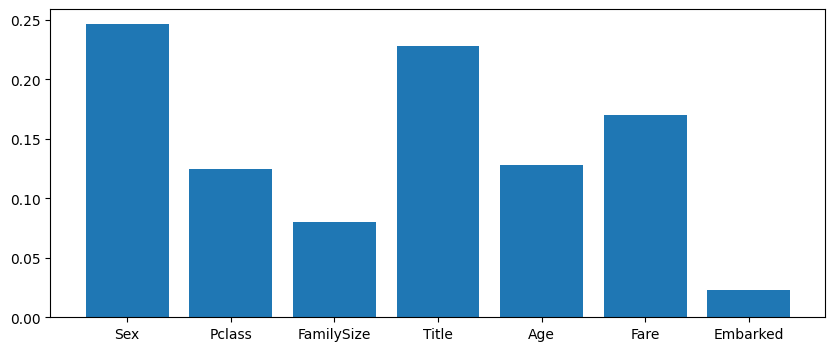

In [ ]:
# Init a model
rf_model = RandomForestClassifier(criterion='gini', oob_score=True, random_state=42)

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [25, 50, 100, 150, 200],
          'min_samples_split': [2, 4, 8, 16, 20, 25, 30],
          'min_samples_leaf': [1, 5, 10, 15]}

# Train the model
rf_model = train_tree_model(X, y, rf_model, params)

<a name="2-2"></a>
### 2.2. Plot a single decision tree of the Random Forest

Будь ласка, перегляньте [sklearn.tree.export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html).

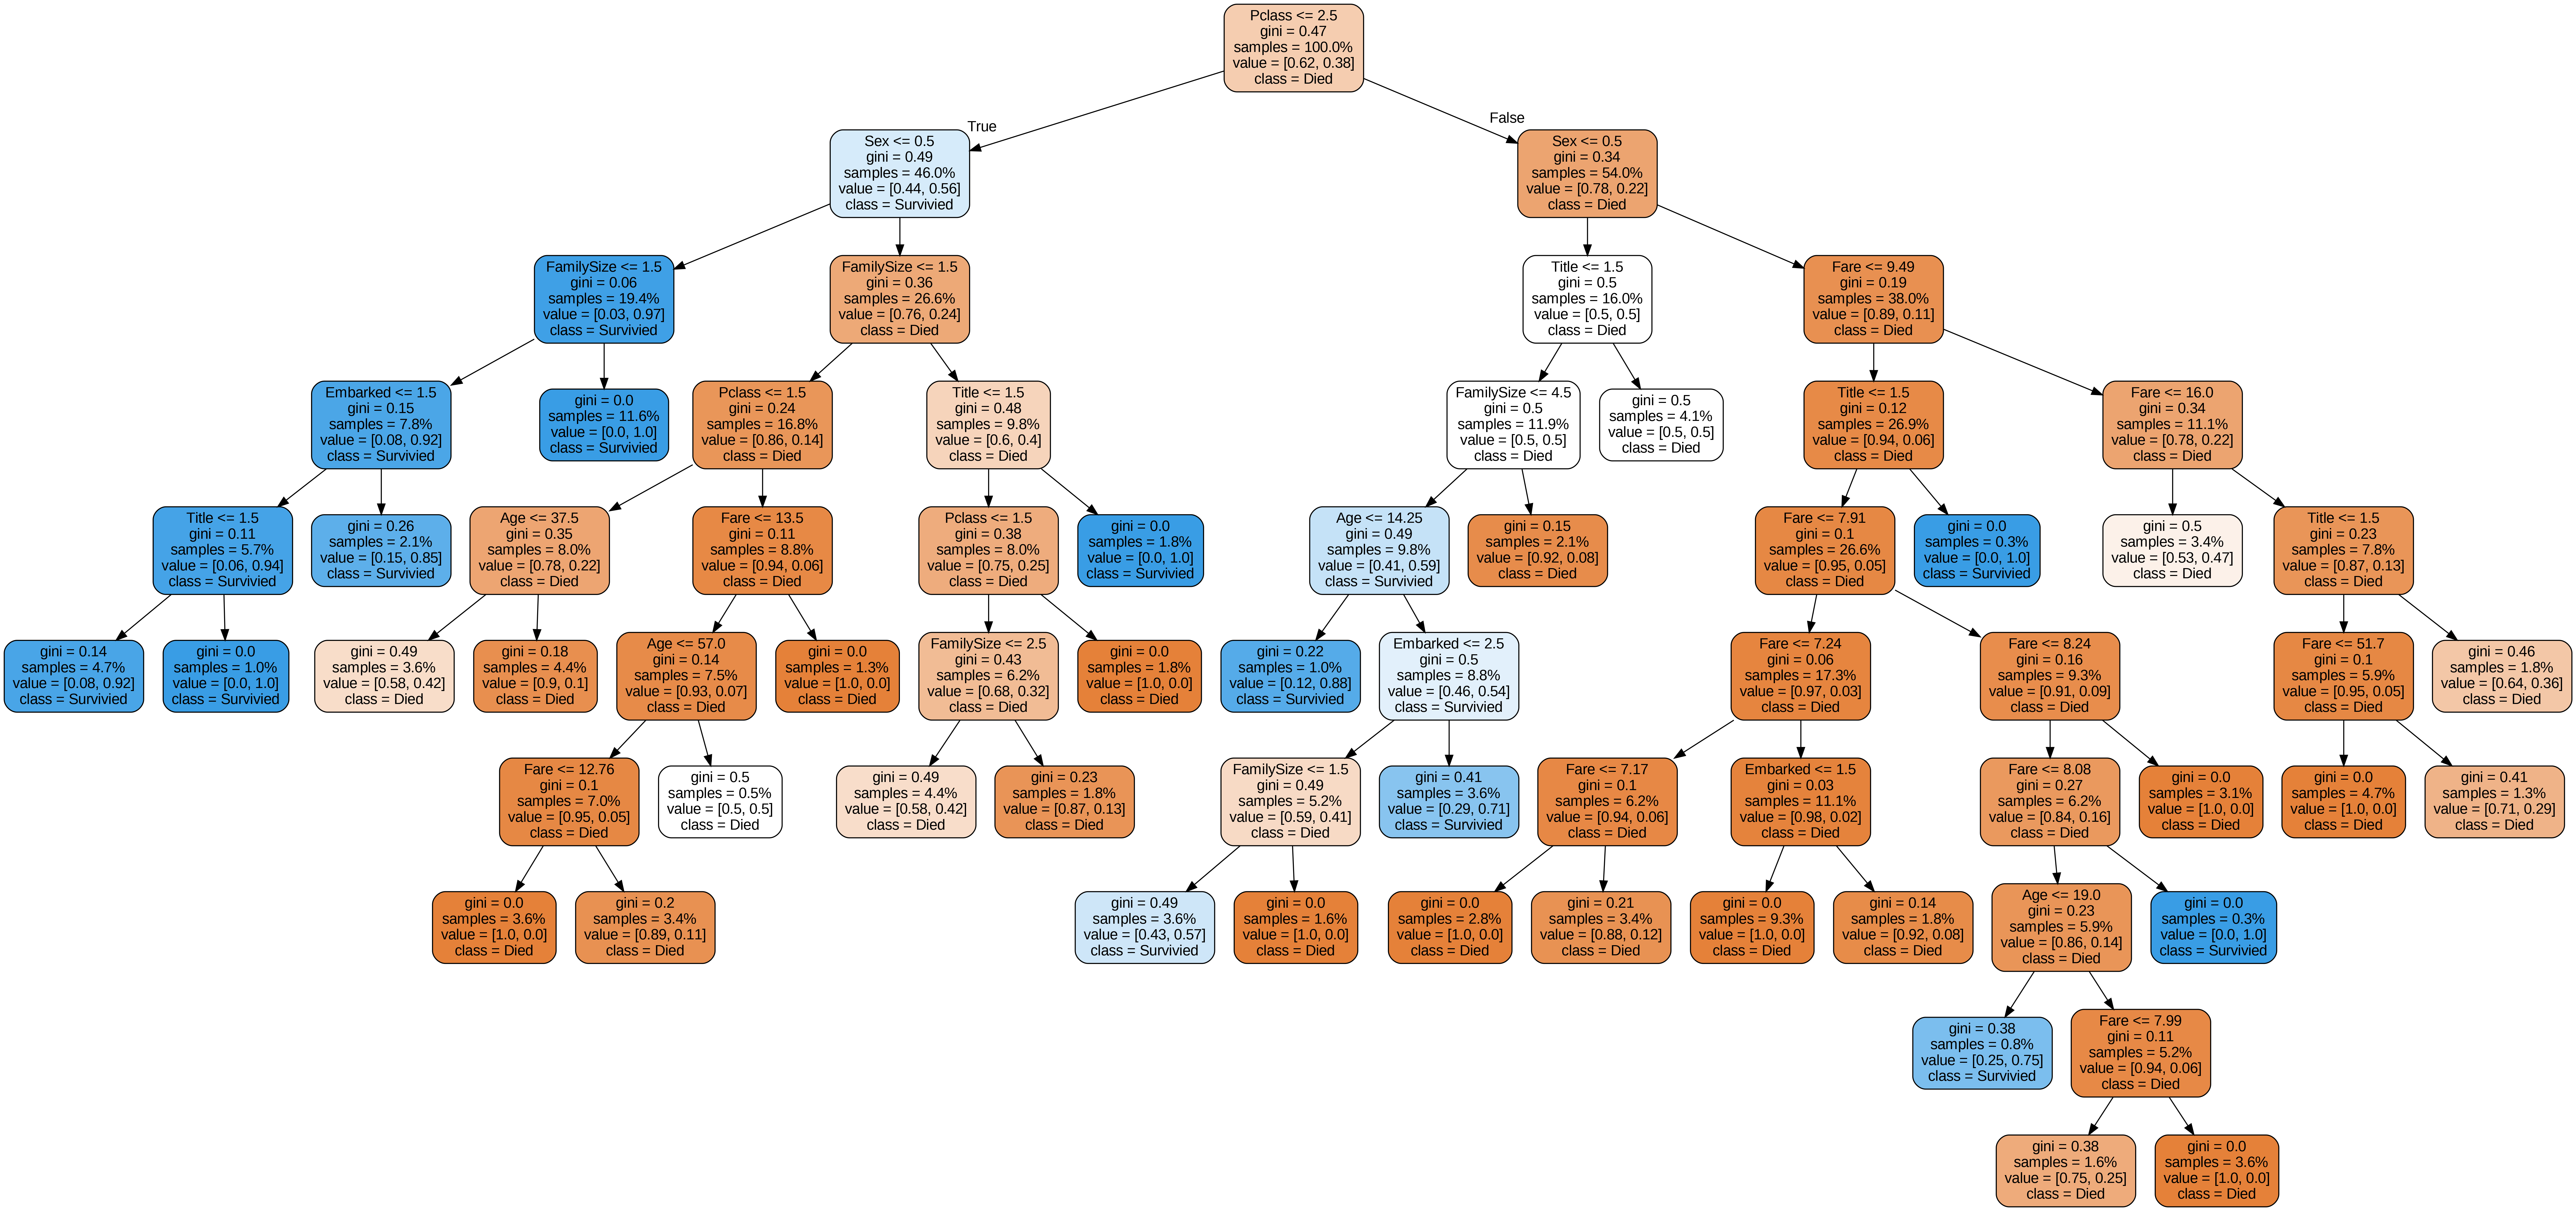

In [ ]:
# Export the 5th tree as dot file
export_graphviz(rf_model.estimators_[15], out_file='tree.dot',
                feature_names = selected_features, class_names = ['Died', 'Survivied'],
                rounded = True, proportion = True, precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=300'])

# Display in jupyter notebook
Image(filename = 'tree.png')

<a name="3"></a>
## 3. Gradient Boosting

<a name="3-1"></a>
### 3.1. XGBoost

Будь ласка, перегляньте [XGBoost](https://xgboost.readthedocs.io/en/latest/), і встановіть бібліотеку `xgboost`.

Деякі важливі параметри ([XGBoost Scikit-Learn API ](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)):
+ **n_estimators** (default=100). Це кількість дерев.
+ **learning_rate** (default=0.1). Це швидкість навчання (xgb’s “eta”).
+ **max_depth** (default=3). Максимальна глибина дерева.
+ **booster** (default=gbtree). Який бустер використовувати. Може бути `gbtree`, `gblinear` або `dart`; `gbtree` і `dart` використовують деревовидні моделі, а `gblinear` - лінійні функції.

PARAMETER GRID:
(number of grid elements: 140)
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 45}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 10}
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 25}
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30}
...........................................

BEST ESTIMATOR:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=Non

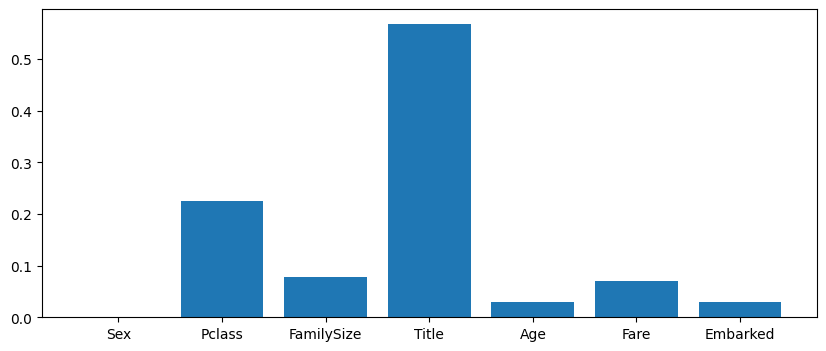

In [ ]:
# Instantiate a model
xgb_model = xgb.XGBClassifier()

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [10, 25, 30, 45, 50, 75, 100],
          'learning_rate': [0.1, 0.01, 0.001, 0.0001],
          'max_depth': range(3, 8)}

# Train the model
xgb_model = train_tree_model(X, y, xgb_model, params);

<a name="3-2"></a>
### 3.2. Plot a single XGBoost decision tree

Запуск коду створює графік першого дерева рішень у моделі (індекс 0), що показує ознаки та значення ознак для кожного розбиття, а також вузли вихідних листків. Функція **plot_tree()** приймає деякі параметри. Ви можете побудувати конкретні графіки, вказавши їх індекс у аргументі `num_trees`.

```python
plot_tree(model, num_trees=4)
```

Ви також можете змінити розташування графіка на зліва направо (зручніше для читання), змінивши аргумент `rankdir` на `LR` (зліва направо), а не на стандартне зверху донизу (UT). Наприклад:

```python
plot_tree(model, num_trees=0, rankdir='LR')
```

Для отримання додаткової інформації, будь ласка, перегляньте [xgboost.plot_tree](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_tree).

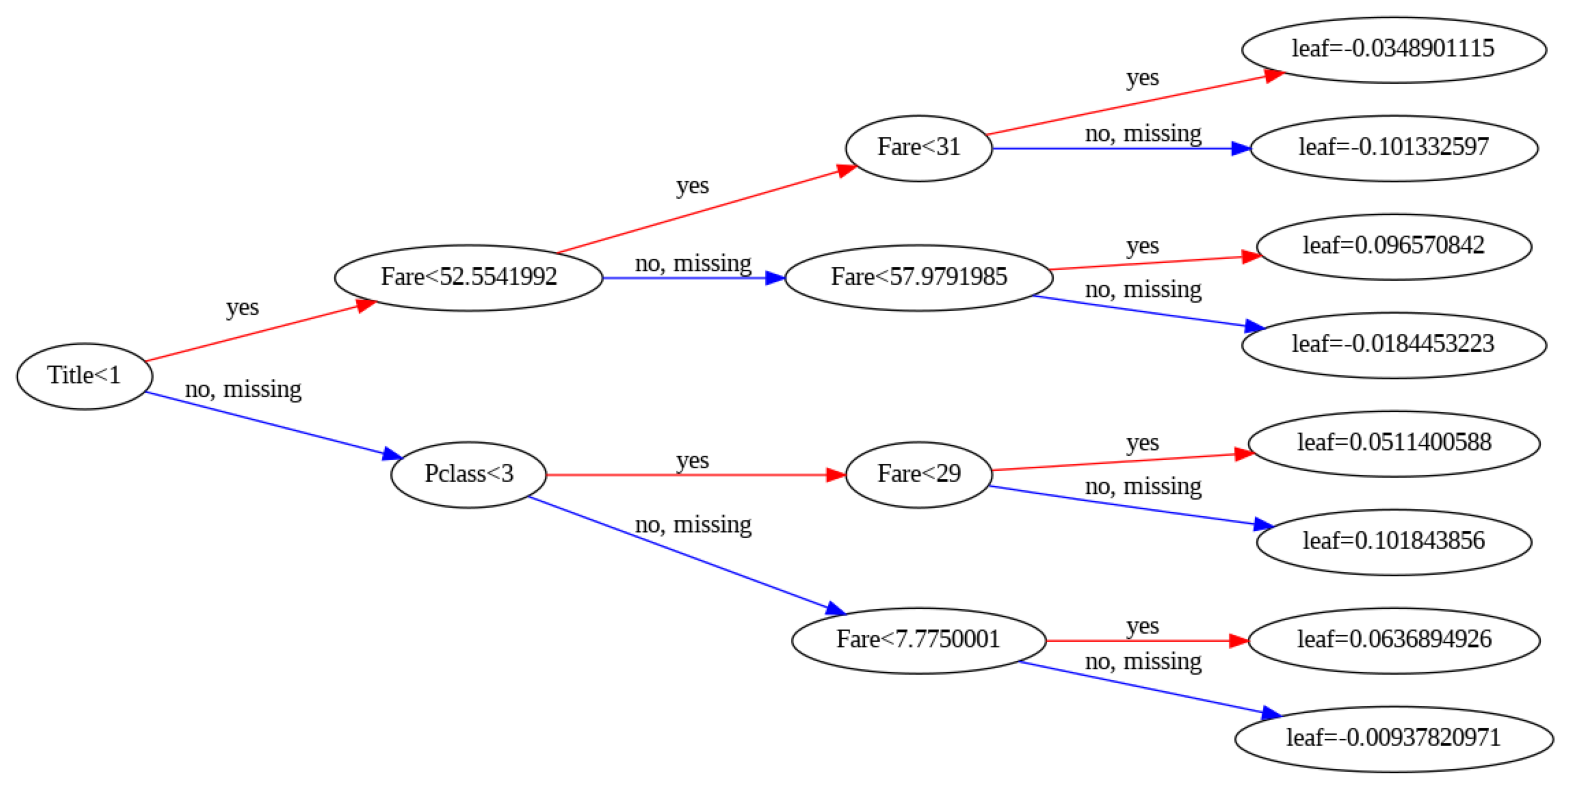

In [ ]:
# Plot 5th decision tree of the XGBoost model
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_tree(xgb_model, num_trees=15, rankdir='LR', ax=ax);

<a name="3-3"></a>
### 3.3. LightGBM

Будь ласка, перегляньте [LightGBM](https://lightgbm.readthedocs.io/en/latest/) та [GitHub - microsoft/LightGBM/Features](https://github.com/microsoft/LightGBM/blob/master/docs/Features.rst), і не забудьте встановити бібліотеку `lightgbm`.

Нагадаємо, що **LightGBM** використовує алгоритм росту дерева [leaf-wise](https://github.com/microsoft/LightGBM/blob/master/docs/Features.rst#leaf-wise-best-first-tree-growth), тоді як **XGBoost** використовують алгоритм росту дерева за глибиною. Порівняно з ростом за глибиною, алгоритм росту за листками може збігатися набагато швидше. Однак, зростання за листками може призвести до надмірної підгонки, якщо його не використовувати з відповідними параметрами.

Для отримання хороших результатів за допомогою leaf-wise необхідно враховувати деякі важливі параметри:

+ **n_estimators** (or **num_iterations**; default = 100). Це кількість ітерацій. Зауваження: внутрішньо LightGBM будує дерева `num_class * num_iterations` для задач багатокласової класифікації.
+ **learning_rate** (default = 0.1). Це швидкість навчання.
+ **num_leaves** (default = 31). Це основний параметр для керування складністю деревовидної моделі. Теоретично, ми можемо задати $num\_leaves = 2^{max\_depth}$ щоб отримати таку саму кількість листків, що й у глибинному дереві. Однак, це просте перетворення не працює на практиці. Причина полягає в тому, що дерево за кількістю листків, як правило, набагато глибше, ніж дерево за глибиною для фіксованої кількості листків. Необмежена глибина може призвести до надмірної підгонки. Таким чином, при спробі налаштувати num_leaves, ми повинні залишити його меншим за $2^{max\_depth}$. Наприклад, коли `max_depth=7` дерево за глибиною може дати хорошу точність, але встановлення `num_leaves` у 127 може призвести до надмірної підгонки, а встановлення цього параметра у 70 або 80 може дати кращу точність, ніж за глибиною.
+ **min_data_in_leaf** (default = 20). Це дуже важливий параметр для запобігання овертфітингу в дереві, побудованому за принципом листя. Його оптимальне значення залежить від кількості навчальних вибірок та `num_leaves`. Встановлення його на велике значення дозволяє уникнути вирощування занадто глибокого дерева, але може призвести до недостатньої підгонки. На практиці для великого набору даних достатньо встановити значення в сотні або тисячі.
+ **max_depth** (default = -1; <= 0 means no limit). Ви також можете використовувати `max_depth` для явного обмеження глибини дерева.

PARAMETER GRID:
(number of grid elements: 600)
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 5, 'num_leaves': 5}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 5, 'num_leaves': 10}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 5, 'num_leaves': 15}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 25, 'num_leaves': 5}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 25, 'num_leaves': 10}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 25, 'num_leaves': 15}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 50, 'num_leaves': 5}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 50, 'num_leaves': 10}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 50, 'num_leaves': 15}
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_i

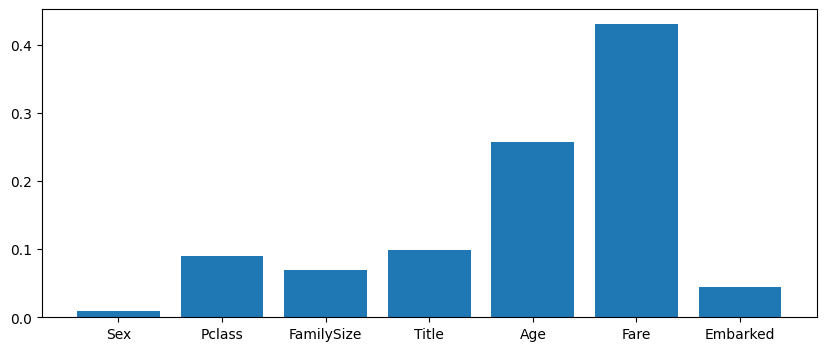

In [ ]:
# Instantiate a model
lgbm_model = lgb.LGBMClassifier(verbose=-100)

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [5, 25, 50, 100, 150],
          'learning_rate': [0.1, 0.01, 0.001, 0.0001],
          'num_leaves': [5, 10, 15],
          'min_data_in_leaf': [20, 30],
          'max_depth': range(3, 8),
          }

# Train the model
lgbm_model = train_tree_model(X, y, lgbm_model, params)

<a name="3-4"></a>
### 3.4. Plot a single LightGBM decision tree

Будь ласка, перегляньте [lightgbm.plot_tree](https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.plot_tree).

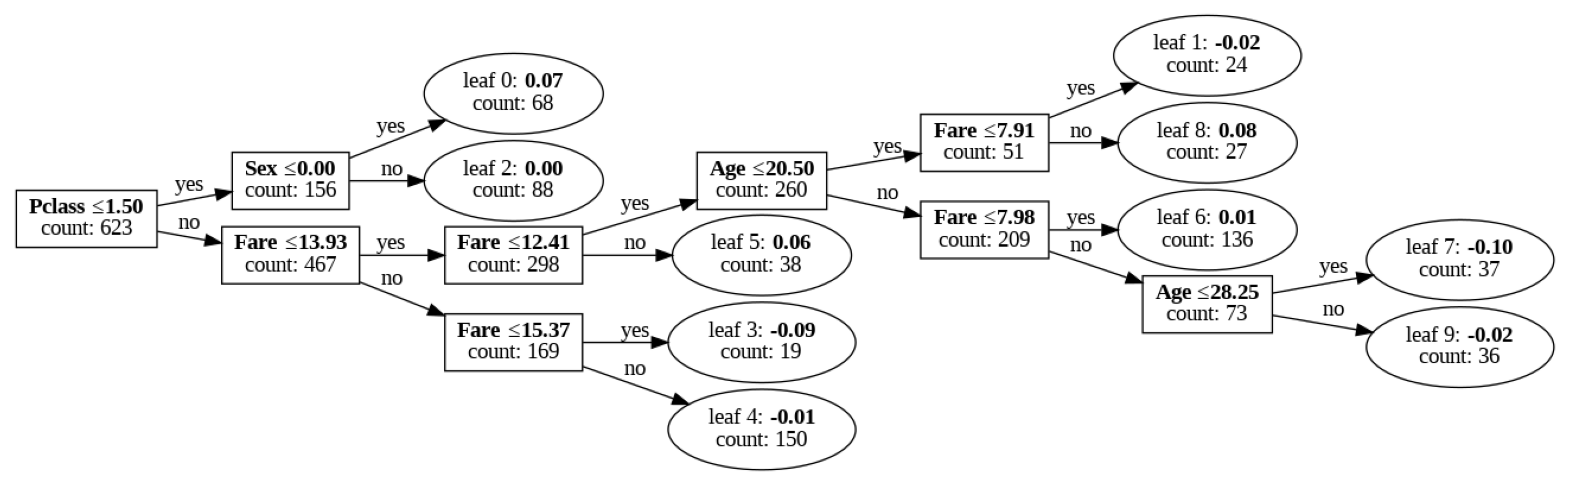

In [ ]:
# Plot 5th decision tree of the LightGBM model
ax = lgb.plot_tree(lgbm_model, tree_index=45, figsize=(20, 10), precision=2, show_info=['internal_count', 'leaf_count'])
plt.show()

<a name="4"></a>
## 4. AUC - ROC curve

**Receiver operating characteristic curve**, або [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), це графік, який ілюструє точність прогнозу системи бінарного класифікатора при зміні його порогу.

ROC-крива створюється шляхом накладання **true positive rate (TPR)** на **false positive rate (FPR)** при різних порогових значеннях.

![](https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png)

У бінарній класифікації передбачення класу для кожного екземпляра часто робиться на основі неперервної випадкової величини $X$, яка є "оцінкою", обчисленою для екземпляра (наприклад, оцінкою ймовірності в логістичній регресії). За заданим пороговим параметром $T$ екземпляр класифікується як "positive", якщо $X>T$, і "negative" у протилежному випадку. $X$ відповідає ймовірності $f_{1}(x)$, якщо екземпляр дійсно належить до класу "positive", і $f_{0}(x)$, якщо ні. Таким чином, частота істинно позитивних результатів визначається як $TPR(T)=\int _{T}^{\infty }{f_{1}(x)\,dx}$, а частота хибнопозитивних результатів визначається як $FPR(T)=\int _{T}^{\infty }{f_{0}(x)\,dx}$. ROC-крива показує параметричну залежність $TPR(T)$ від $FPR(T)$ з $T$ як змінним параметром:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/ROC_curves.svg/500px-ROC_curves.svg.png)

[AUC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5), або **Area Under the [ROC] Curve**, представляє ступінь або міру розділюваності і показує, наскільки модель здатна розрізняти класи. Чим вищий AUC, тим краще модель прогнозує 0 як 0 і 1 як 1.

Відмінна модель має AUC, близьке до 1, що означає, що вона має хорошу роздільну здатність. Погана модель має AUC близько до 0, що означає, що вона має найгіршу міру класифікації. Фактично, це означає, що модель дає зворотній результат, тобто, вона прогнозує 0 як 1, а 1 як 0. А коли AUC дорівнює 0,5, це означає, що модель взагалі не має здатності розділяти класи, а працює випадковим чином.

Please review:
+ [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
+ [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

**Note:** вони обмежені завданням бінарної класифікації.

1 place, AUC of the Random Forest model: 0.939
2 place, AUC of the LightGBM model: 0.927
3 place, AUC of the XGBoost model: 0.917



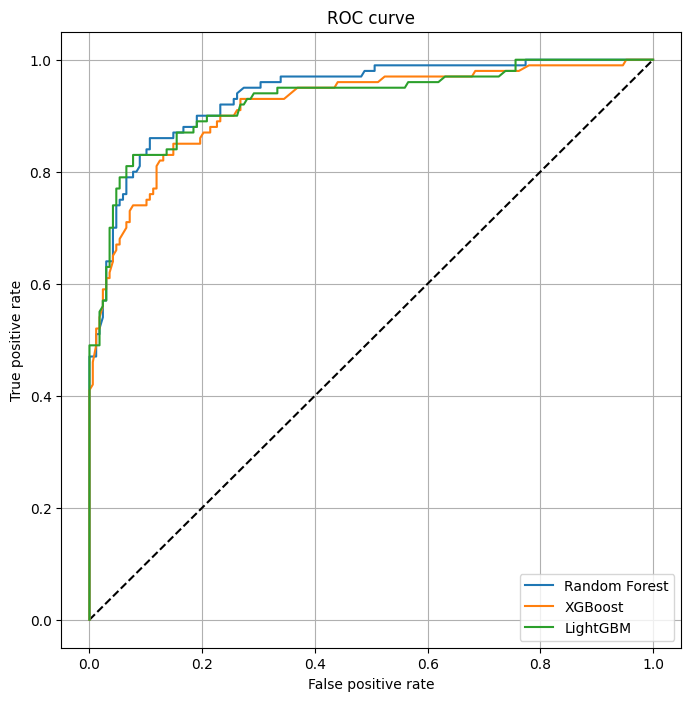

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=0)

# Random Forest ROC curve
y_dev_pred_rf = rf_model.predict_proba(X_dev)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_dev, y_dev_pred_rf)

# XGBoost ROC curve
y_dev_pred_xgb = xgb_model.predict_proba(X_dev)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_dev, y_dev_pred_xgb)

# LightGBM ROC curve
y_dev_pred_lgbm = lgbm_model.predict_proba(X_dev)[:, 1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_dev, y_dev_pred_lgbm)

# Calculate AUC values
aucs = []
aucs.append(('Random Forest', roc_auc_score(y_dev, y_dev_pred_rf)))
aucs.append(('XGBoost', roc_auc_score(y_dev, y_dev_pred_xgb)))
aucs.append(('LightGBM', roc_auc_score(y_dev, y_dev_pred_lgbm)))

# Display sorted AUC values
for i, (name, auc) in enumerate(sorted(aucs, key=lambda x: x[1], reverse=True)):
    print(f"{i+1} place, AUC of the {name} model: {auc:.3f}")
print()

# Plot the ROC cures
fig = plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()